In [530]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from kaggle.competitions import nflrush
import tqdm
import re
from string import punctuation

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [531]:
source_train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})

In [532]:
train = source_train.copy()

In [533]:
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


# Feature engineering

In [534]:
train['DefendersInTheBox_vs_Distance'] = train['DefendersInTheBox'] / train['Distance']

In [535]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))
cat_features

[('Team', 2),
 ('DisplayName', 2230),
 ('GameClock', 901),
 ('PossessionTeam', 32),
 ('FieldPosition', 33),
 ('OffenseFormation', 9),
 ('OffensePersonnel', 56),
 ('DefensePersonnel', 38),
 ('PlayDirection', 2),
 ('TimeHandoff', 22935),
 ('TimeSnap', 22943),
 ('PlayerHeight', 16),
 ('PlayerBirthDate', 1688),
 ('PlayerCollegeName', 301),
 ('Position', 25),
 ('HomeTeamAbbr', 32),
 ('VisitorTeamAbbr', 32),
 ('Stadium', 55),
 ('Location', 60),
 ('StadiumType', 30),
 ('Turf', 20),
 ('GameWeather', 62),
 ('WindSpeed', 41),
 ('WindDirection', 54)]

## Clean stadium type

In [536]:
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt
train['StadiumType'] = train['StadiumType'].apply(clean_StadiumType)

Make a new feature of short stadium type

In [537]:
train['StadiumType'][pd.isna(train['StadiumType'])].shape

(32934,)

In [538]:
def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    
    return np.nan
train['StadiumTypeShort'] = train['StadiumType'].apply(transform_StadiumType)

In [539]:
train['StadiumTypeShort'][train['StadiumTypeShort'].isnull()].shape

(70620,)

In [540]:
train = train.drop(['StadiumType'], axis=1)

## Turf

In [541]:
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

turf_type = train['Turf'].map(Turf)
train['TurfIsNatural'] = turf_type == 'Natural'

In [542]:
train = train.drop(['Turf'], axis=1)

## Posession team

In [543]:
train[(train['PossessionTeam']!=train['HomeTeamAbbr']) & (train['PossessionTeam']!=train['VisitorTeamAbbr'])][['PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr']].shape

(63822, 3)

In [544]:
diff_abbr = []
for x,y  in zip(sorted(train['HomeTeamAbbr'].unique()), sorted(train['PossessionTeam'].unique())):
    if x!=y:
        print(x + " " + y)

ARI ARZ
BAL BLT
CLE CLV
HOU HST


In [545]:
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train['PossessionTeam'].unique():
    map_abbr[abb] = abb

In [546]:
train['PossessionTeam'] = train['PossessionTeam'].map(map_abbr)
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].map(map_abbr)
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].map(map_abbr)

Feature: is home in posession

In [547]:
train['HomePossesion'] = train['PossessionTeam'] == train['HomeTeamAbbr']

In [548]:
train['Field_eq_Possession'] = train['FieldPosition'] == train['PossessionTeam']
train['HomeField'] = train['FieldPosition'] == train['HomeTeamAbbr']

# Feature: is on the offense

Also used for sorting

In [549]:
train['InPosession']=(((train.Team == 'home') & (train.PossessionTeam == train.HomeTeamAbbr)) | ((train.Team == 'away') & (train.PossessionTeam == train.VisitorTeamAbbr)))

In [550]:
train[['PlayId', 'Team', 'PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'FieldPosition', 'InPosession']].head(23)

,PlayId,Team,PossessionTeam,HomeTeamAbbr,VisitorTeamAbbr,FieldPosition,InPosession
0,20170907000118,away,NE,NE,KC,NE,False
1,20170907000118,away,NE,NE,KC,NE,False
2,20170907000118,away,NE,NE,KC,NE,False
3,20170907000118,away,NE,NE,KC,NE,False
4,20170907000118,away,NE,NE,KC,NE,False
5,20170907000118,away,NE,NE,KC,NE,False
6,20170907000118,away,NE,NE,KC,NE,False
7,20170907000118,away,NE,NE,KC,NE,False
8,20170907000118,away,NE,NE,KC,NE,False
9,20170907000118,away,NE,NE,KC,NE,False


## Offense formation

In [551]:
train = pd.concat([train.drop(['OffenseFormation'], axis=1), pd.get_dummies(train['OffenseFormation'], prefix='Formation')], axis=1)
# dummy_col = train.columns

## Game clock

In [552]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans
train['GameClock'] = train['GameClock'].apply(strtoseconds)

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


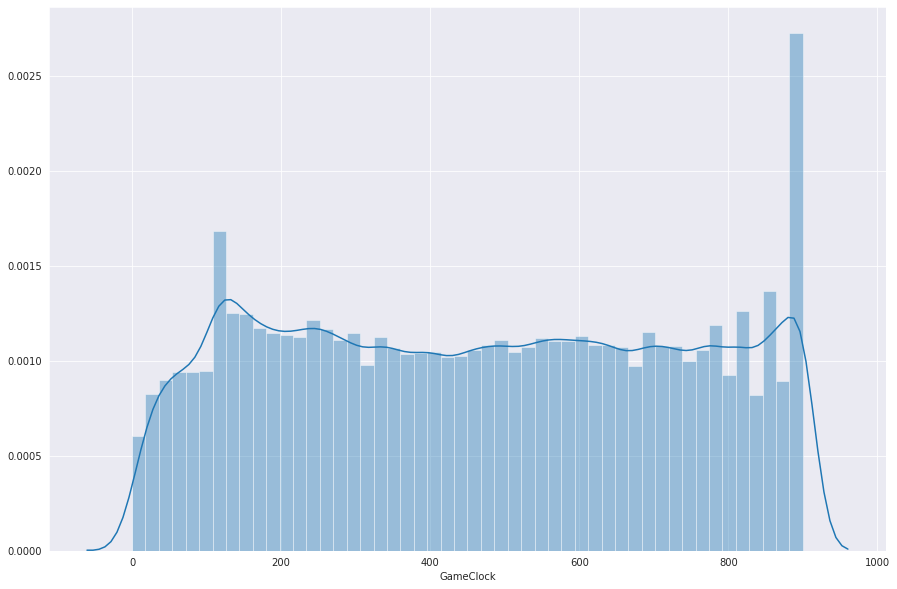

In [553]:
sns.distplot(train['GameClock'])

## Player height

In [554]:
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

In [555]:
train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)

## Time hand off, time snap

In [556]:
train['TimeSnap'].head()

0    2017-09-08T00:44:05.000Z
1    2017-09-08T00:44:05.000Z
2    2017-09-08T00:44:05.000Z
3    2017-09-08T00:44:05.000Z
4    2017-09-08T00:44:05.000Z
Name: TimeSnap, dtype: object

In [557]:
train['TimeHandoff'] = pd.to_datetime(train['TimeHandoff'], utc=True)
train['TimeSnap'] = pd.to_datetime(train['TimeSnap'], utc=True)

In [558]:
train['TimeSnap'].head()

0   2017-09-08 00:44:05+00:00
1   2017-09-08 00:44:05+00:00
2   2017-09-08 00:44:05+00:00
3   2017-09-08 00:44:05+00:00
4   2017-09-08 00:44:05+00:00
Name: TimeSnap, dtype: datetime64[ns, UTC]

In [559]:
# train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1).shape

In [560]:
# (train['TimeHandoff']-train['TimeSnap']).apply(lambda x: x.total_seconds()).shape

In [561]:
# train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
# train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

Feature: diff between handoff and snap

In [562]:
train['TimeDelta'] = (train['TimeHandoff']-train['TimeSnap']).apply(lambda x: x.total_seconds())

In [563]:
train['PlayerBirthDate'].head()

0    12/29/1988
1    03/25/1989
2    01/21/1989
3    11/22/1982
4    08/17/1987
Name: PlayerBirthDate, dtype: object

In [564]:
train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [565]:
train['PlayerBirthDate'] = pd.to_datetime(train['PlayerBirthDate'], utc=True)
train['PlayerBirthDate'].head()

0   1988-12-29 00:00:00+00:00
1   1989-03-25 00:00:00+00:00
2   1989-01-21 00:00:00+00:00
3   1982-11-22 00:00:00+00:00
4   1987-08-17 00:00:00+00:00
Name: PlayerBirthDate, dtype: datetime64[ns, UTC]

In [566]:
train['PlayerBirthDate'].head()

0   1988-12-29 00:00:00+00:00
1   1989-03-25 00:00:00+00:00
2   1989-01-21 00:00:00+00:00
3   1982-11-22 00:00:00+00:00
4   1987-08-17 00:00:00+00:00
Name: PlayerBirthDate, dtype: datetime64[ns, UTC]

## Player age

In [567]:
train['TimeHandoff'].head()

0   2017-09-08 00:44:06+00:00
1   2017-09-08 00:44:06+00:00
2   2017-09-08 00:44:06+00:00
3   2017-09-08 00:44:06+00:00
4   2017-09-08 00:44:06+00:00
Name: TimeHandoff, dtype: datetime64[ns, UTC]

In [568]:
train['PlayerBirthDate'].head()

0   1988-12-29 00:00:00+00:00
1   1989-03-25 00:00:00+00:00
2   1989-01-21 00:00:00+00:00
3   1982-11-22 00:00:00+00:00
4   1987-08-17 00:00:00+00:00
Name: PlayerBirthDate, dtype: datetime64[ns, UTC]

In [569]:
# train['TimeHandoff']-train['PlayerBirthDate']

In [570]:
seconds_in_year = 60*60*24*365.25
train['PlayerAge'] = (train['TimeHandoff']-train['PlayerBirthDate']).apply(lambda x: x.total_seconds())/seconds_in_year

In [571]:
train['PlayerAge'].head()

0    28.692760
1    28.457305
2    28.629790
3    34.795430
4    30.061685
Name: PlayerAge, dtype: float64

In [572]:
train = train.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)

## Windspeed

In [573]:
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)

In [574]:
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
train['WindSpeed'] = train['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)

In [575]:
def str_to_float(txt):
    try:
        return float(txt)
    except Exception as e:
        return np.NaN

In [576]:
train['WindSpeed'] = train['WindSpeed'].apply(str_to_float)

In [577]:
train['WindSpeed'][train['WindSpeed'].isnull()].shape

(71632,)

Fill nans: PAD

In [578]:
# train['WindSpeed'] = train['WindSpeed'].fillna(method='pad')

In [579]:
train['WindSpeed'].describe()

count    438130.000000
mean          7.468792
std           4.390420
min           0.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          24.000000
Name: WindSpeed, dtype: float64

## Wind direction

Just drop it

In [580]:
train = train.drop(['WindDirection'], axis=1)

## Play direction

In [581]:
train['PlayDirection'] = train['PlayDirection'].apply(lambda x: x.strip() == 'right')

## Team

In [582]:
train['IsHomeTeam'] = train['Team'].apply(lambda x: x.strip()=='home')

## Weather

In [583]:
train['GameWeather'] = train['GameWeather'].str.lower()
indoor = "indoor"
train['GameWeather'] = train['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

In [584]:
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0
train['GameWeather'] = train['GameWeather'].apply(map_weather)

## Rusher

In [585]:
train['IsRusher'] = train['NflId'] == train['NflIdRusher']

Maybe NFLID is connected to how long a player had been playing?

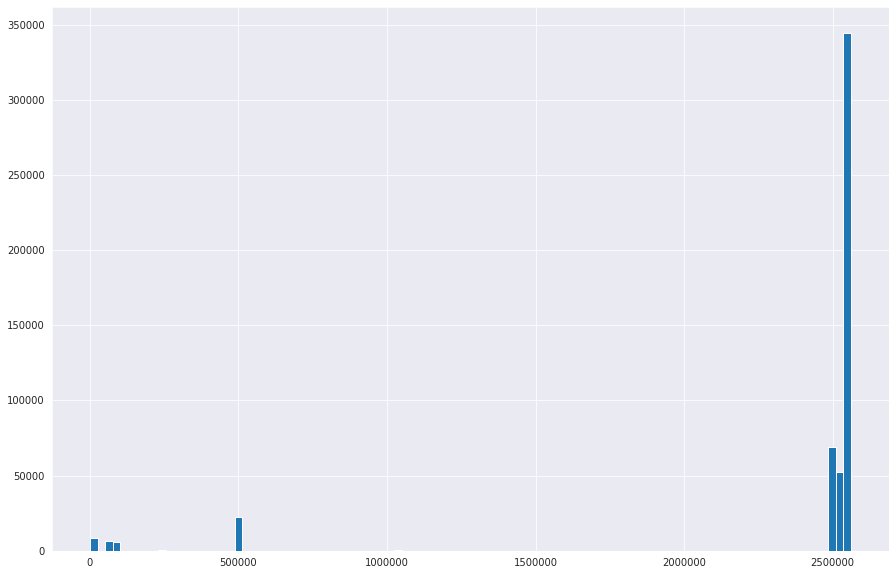

In [586]:
train['NflId'].hist(bins=100)

In [587]:
# train[train['NflId'] <= 500000].head().T

In [ ]:
train.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)

## Play direction, orientation, dir

In [ ]:
train['X'] = train.apply(lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)

In [ ]:
def new_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
    
train['Orientation'] = train.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
train['Dir'] = train.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)

## Yards left

In [ ]:
train['YardsLeft'] = train.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
train['YardsLeft'] = train.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

In [ ]:
# train.drop(train.index[(train['YardsLeft']<train['Yards']) | (train['YardsLeft']-100>train['Yards'])], inplace=True)

## DefensePersonnel

In [ ]:
train['DefensePersonnel'].value_counts()

In [ ]:
train['DefensePersonnel'].head()

In [ ]:
counts = []
for i, val in train['DefensePersonnel'].str.split(',').iteritems():
    row = {'DL':0,
          'LB': 0,
          'DB': 0,
          'OL': 0}
    if val is np.NaN:
        counts.append({})
        continue
    for item in val:
        name, number = item.strip().split(' ')[::-1]
        row[name] = int(number)
    counts.append(row)
defense_presonell_df = pd.DataFrame(counts)
defense_presonell_df.columns = ['defense_'+x for x in defense_presonell_df.columns]
defense_presonell_df = defense_presonell_df.fillna(0).astype(int)
defense_presonell_df.index = train.index
defense_presonell_df.head()

In [ ]:
train = pd.concat([train.drop(['DefensePersonnel'], axis=1), defense_presonell_df], axis=1)
train.head()

## OffensePersonnel

In [ ]:
train['OffensePersonnel'].value_counts()

In [ ]:
counts = []
for i, val in train['OffensePersonnel'].str.split(',').iteritems():
    row = {'OL': 0, 'RB': 0, 'TE': 0, 'WR': 0, 'DL': 0}
    if val is np.NaN:
        counts.append({})
        continue
    for item in val:
        name, number = item.strip().split(' ')[::-1]
        row[name] = int(number)
    counts.append(row)
offense_personnel_df = pd.DataFrame(counts)
offense_personnel_df.columns = ['offense_'+x for x in offense_personnel_df.columns]
offense_personnel_df = offense_personnel_df.fillna(0).astype(int)
offense_personnel_df.index = train.index
offense_personnel_df.head()

In [ ]:
train = pd.concat([train.drop(['OffensePersonnel'], axis=1), offense_personnel_df], axis=1)
train.head()

In [ ]:
# pd.DataFrame(counts)

In [ ]:
train.columns

In [ ]:
train.isnull().sum(axis=0)[train.isnull().sum(axis=0)>0]

## Sort players somehow

In [ ]:
# Offenders first
train = train.sort_values(by=['PlayId', 'InPosession', 'IsRusher']).reset_index(drop=True)
train.head()

In [ ]:
source_play_id = train['PlayId']

# Assemble $(X, y)$ matrix

In [ ]:
train_preproc = train.copy()
train_preproc.index = source_play_id

Drop useless columns

In [ ]:
train_preproc.columns

In [ ]:
cols_delete = ['GameId', 'PlayId', 'IsRusher', 'Team']

In [ ]:
train_preproc = train_preproc.drop(cols_delete, axis=1)
train_preproc.shape

In [ ]:
train_preproc.head()

In [ ]:
# list(train_preproc.columns)

## Fill NaN values

In [ ]:
# train_preproc = train_preproc.fillna(-999)#method='pad')
# Not fill NA at all because LGB works better with NaN

## Drop text features

In [ ]:
cat_features = []
for col in train_preproc.columns:
    if train_preproc[col].dtype =='object':
        cat_features.append(col)

In [ ]:
cat_features

In [ ]:
train_preproc = train_preproc.drop(cat_features, axis=1)

# Matrix of player features

In [ ]:
train_preproc.head()

In [ ]:
train_preproc.shape

In [ ]:
cols_player = ['X',
 'Y',
 'S',
 'A',
 'Dis',
 'Orientation',
 'Dir',
 'JerseyNumber',
 'PlayerHeight',
 'PlayerWeight',
 'PlayerBMI',
 'PlayerAge']

In [ ]:
train_preproc[cols_player].head(23)

In [ ]:
all_cols_player = np.array([[f'pl{num}_'+x for x in cols_player] for num in range(1, 23)]).flatten()

all_cols_player[:13]

In [ ]:
play_id_index = source_play_id[::22]

In [ ]:
X_train = np.array(train_preproc[cols_player]).reshape(-1, len(cols_player)*22)

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=all_cols_player, index=play_id_index)
X_train_df.head()

In [ ]:
train_preproc[cols_player].shape, X_train_df.shape

In [ ]:
assert train_preproc[cols_player].shape[0] == X_train_df.shape[0] * 22
assert train_preproc[cols_player].shape[1] == X_train_df.shape[1] / 22

# Matrix of play features

In [ ]:
cols_play = list(train_preproc.drop(cols_player+(['Yards'] if 'Yards' in train.columns else []), axis=1).columns)

In [ ]:
cols_play

In [ ]:
train_preproc[cols_play].shape

In [ ]:
X_train_df.shape

In [ ]:
X_play_col = np.zeros(shape=(X_train.shape[0], len(cols_play)))
for i, col in enumerate(cols_play):
    X_play_col[:, i] = train_preproc[col][::22]

In [ ]:
X_play_col.shape

In [ ]:
X_play_col_df = pd.DataFrame(X_play_col, columns=cols_play, index=play_id_index)
X_play_col_df.head()

In [ ]:
assert X_play_col_df.shape[0] == X_train_df.shape[0]

In [ ]:
X_train.shape, X_play_col.shape

In [ ]:
X_train_df = pd.concat([X_train_df, X_play_col_df], axis=1)
X_train_df.shape

In [ ]:
assert X_train_df.shape[0] == train['PlayId'].drop_duplicates().count()

# Target

In [ ]:
y_train = np.zeros(shape=(X_train_df.shape[0], 199))
for i,yard in enumerate(train_preproc['Yards'][::22]):
    y_train[i, yard+99:] = np.ones(shape=(1, 100-yard))

In [ ]:
y_train[0]

In [ ]:
X_train.shape, y_train.shape

In [ ]:
assert X_train.shape[0] == y_train.shape[0]

# Preprocessing pipeline functions

In [ ]:
%load_ext autoreload
%aimport utils
%autoreload 1
import utils

In [ ]:
df_preproc = utils.preprocess_features(source_train)

In [ ]:
assert (df_preproc.dropna().values == train.dropna().values).all(), 'You changed something in the preprocessing code, but didn\'t change utils functions accordingly. Fix it'

In [ ]:
# train.isnull().sum(axis=0)[train.isnull().sum(axis=0)>0]

In [ ]:
# df_preproc.isnull().sum(axis=0)[df_preproc.isnull().sum(axis=0)>0]

In [ ]:
X_train_ = utils.make_x(df_preproc)
y_train_ = utils.make_y(X_train_, df_preproc)

In [ ]:
set(df_preproc.columns).difference(train.columns)

In [ ]:
set(train.columns).difference(df_preproc.columns)

In [ ]:
assert (X_train_.dropna() == X_train_df.dropna()).all().all(), 'You changed something in the code of making X, but didn\'t change utils functions accordingly. Fix it'
assert (y_train_ == y_train).all(), 'You changed something in the code of making Y, but didn\'t change utils functions accordingly. Fix it'
print('all good')

In [ ]:
# (train != df_preproc).sum(axis=0)

In [ ]:
# df_preproc[df_preproc.isnull().any(axis=1)].shape

In [ ]:
# train[train.isnull().any(axis=1)].shape

In [ ]:
# train[(train != df_preproc).any(axis=1)].head()

In [ ]:
# df_preproc[(train.dropna() != df_preproc.dropna()).any(axis=1)].head()

In [ ]:
# (df_preproc.dropna() != train.dropna()).sum(axis=0)

In [ ]:
# df_preproc.dropna().shape, train.dropna().shape

In [ ]:
# y_df = pd.DataFrame(y_train)
# y_df.head()

In [ ]:
# X_df = pd.DataFrame(X_train)
# X_df.head()

In [ ]:
# X_df.to_csv('data/x_train.csv', index=None)

In [ ]:
# y_df.to_csv('data/y_train.csv', index=None)